In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
import warnings
from itertools import permutations

from mlxtend.preprocessing import TransactionEncoder

#from mlxtend.frequent_patterns import apriori
#from mlxtend.frequent_patterns import association_rules

In [80]:
sns.set(style="darkgrid", color_codes=True)
pd.set_option('display.max_columns', 75)

## Dataset

In [81]:
data_df = pd.read_csv('../datasets/market_basket/market_basket.csv', header=None)
data_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [82]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7501 entries, 0 to 7500
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       7501 non-null   object
 1   1       5747 non-null   object
 2   2       4389 non-null   object
 3   3       3345 non-null   object
 4   4       2529 non-null   object
 5   5       1864 non-null   object
 6   6       1369 non-null   object
 7   7       981 non-null    object
 8   8       654 non-null    object
 9   9       395 non-null    object
 10  10      256 non-null    object
 11  11      154 non-null    object
 12  12      87 non-null     object
 13  13      47 non-null     object
 14  14      25 non-null     object
 15  15      8 non-null      object
 16  16      4 non-null      object
 17  17      4 non-null      object
 18  18      3 non-null      object
 19  19      1 non-null      object
dtypes: object(20)
memory usage: 1.1+ MB


In [83]:
data_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,7501,5747,4389,3345,2529,1864,1369,981,654,395,256,154,87,47,25,8,4,4,3,1
unique,115,117,115,114,110,106,102,98,88,80,66,50,43,28,19,8,3,3,3,1
top,mineral water,mineral water,mineral water,mineral water,green tea,french fries,green tea,green tea,green tea,green tea,low fat yogurt,green tea,green tea,green tea,magazines,salmon,frozen smoothie,protein bar,spinach,olive oil
freq,577,484,375,201,153,107,96,67,57,31,22,15,8,4,3,1,2,2,1,1


In [84]:
class MostPopularItemsPlot:
    
    def __init__(self, item_count):
        
        self.item_count = item_count
        self.bins = np.linspace(0, 1, item_count)
        self.colors = plt.cm.rainbow(self.bins)
    
    def draw(self, data):
        frequencies = data.value_counts().head(self.item_count)
        frequencies.plot.bar(color=self.colors, figsize=(13, 5))

        plt.title('Frequency of the most popular items', fontsize=20)
        plt.xticks(rotation = 90)
        plt.grid()
        plt.show()
        
class TopChoicesPlot:
    
    def __init__(self, item_count, source_label):
        
        self.item_count = item_count
        self.source_label = source_label
        self.bins = np.linspace(0, item_count, 1)
        self.colors = plt.cm.Set1(self.bins)

        warnings.filterwarnings('ignore')
        
    def draw(self, df, target):
        
        df[self.source_label] = self.source_label
        df_truncated = data_df.truncate(before = -1, after = self.item_count)
        
        graph = nx.from_pandas_edgelist(df_truncated, source = self.source_label, target=target, edge_attr = True)
        
        plt.rcParams['figure.figsize'] = (13, 13)
        pos = nx.spring_layout(graph)

        nx.draw_networkx_nodes(graph, pos, node_size=12000, node_color = self.colors)
        nx.draw_networkx_edges(graph, pos, width = 3, alpha = 0.6, edge_color='black')
        nx.draw_networkx_labels(graph, pos, font_size=15, font_family='sans-serif')

        plt.axis('off')
        plt.grid()
        plt.title(f'Top {self.item_count} first choices', fontsize = 20)
        plt.show()
        
        return graph

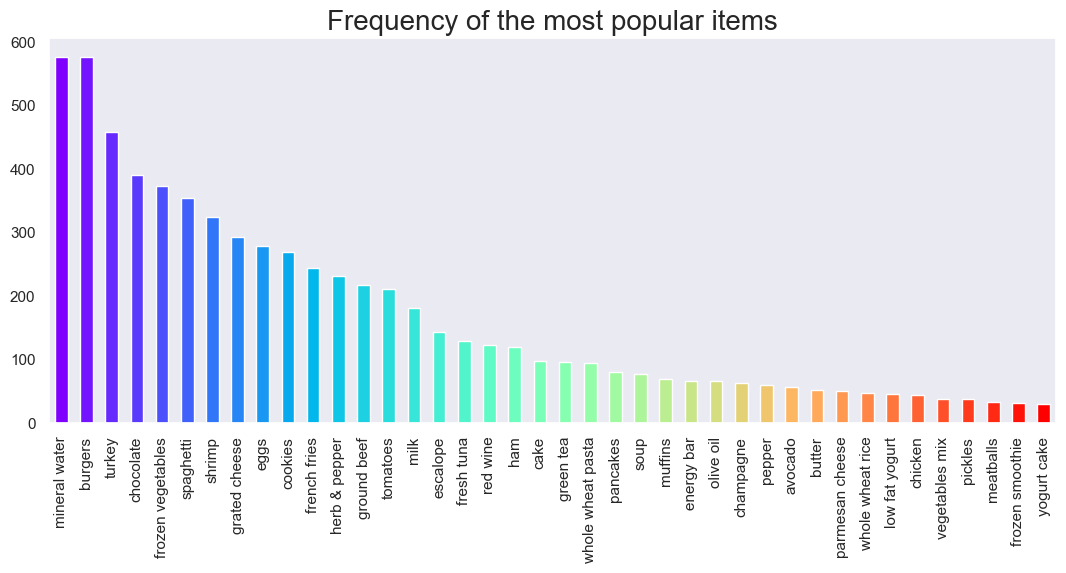

In [85]:
#Previewing most popular items frequencies for a specified column index
#Used for data analysis only. For example food items with bigger frequencies 
#should be correlated with more other items
preview_col = 0

mpi_plot = MostPopularItemsPlot(40)
mpi_plot.draw(data_df[preview_col])

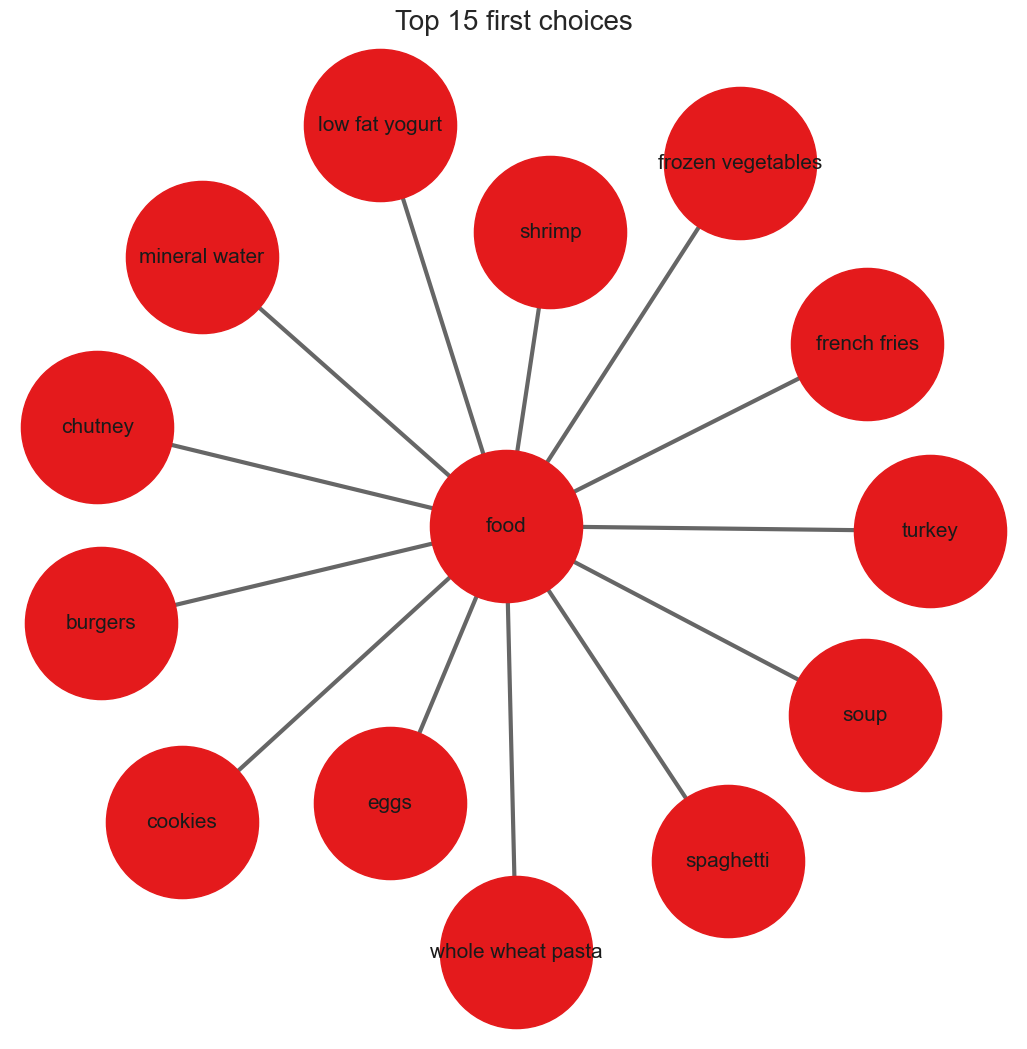

In [86]:
#Previewing top 15 choices for a specified column index
#Used for data analysis only. For example we can see how the number
#of food items descreses for the columns at a right table side
preview_col = 0

tc_plot = TopChoicesPlot(15, 'food')
graph = tc_plot.draw(data_df, preview_col)

## Getting the list of transactions

In [87]:
class RuleList(list):
    
    def __init__(self, items):
        
        super().__init__(self)
        self.extend(list(permutations(items, 2)))
     
    def describe(self):
        print('# of rules:',len(self))
        print(self[:5])
    
class Transaction(list):
    
    def __init__(self, values):
        super().__init__(self)
        self.extend(values)
    
    def from_df(df, row):
        columns_len = len(df.columns)
        values = [str(df.values[row, j]) for j in range(0, columns_len)]
        return Transaction(values)

class TransactionList(list):
    def __init__(self):
        super().__init__(self)
    
    def item_map(self):
        encoder = TransactionEncoder()
        encoder.fit(self)

        encoded_transactions = encoder.transform(self)

        encoded_df = pd.DataFrame(encoded_transactions, columns=encoder.columns_) 
        encoded_df.drop('nan', axis=1)
        return encoded_df
    
    def flatten(self):
        return [item for transaction in self for item in transaction]
    
    def get_items(self, is_unique):
        flattened = self.flatten()
        
        if is_unique:
            items = list(set(flattened))
            if 'nan' in items: 
                items.remove('nan')
            return items
        else:
            return flattened;
    
    def from_df(df):
        df_len = len(df)
        transactions = TransactionList()
        for i in range(0, df_len) :
            transactions.append(Transaction.from_df(df, i))
        
        return transactions

In [88]:
transactions = TransactionList.from_df(data_df)

In [89]:
items = transactions.get_items(is_unique=True)
len(items)

121

In [90]:
rules = RuleList(items)
rules.describe()

# of rules: 14520
[('cream', 'cooking oil'), ('cream', 'shallot'), ('cream', 'chutney'), ('cream', 'mushroom cream sauce'), ('cream', 'burgers')]


In [91]:
item_map_df = transactions.item_map()
item_map_df.head()

,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,body spray,bramble,brownies,bug spray,burger sauce,burgers,butter,cake,candy bars,carrots,cauliflower,cereals,champagne,chicken,chili,chocolate,chocolate bread,chutney,cider,clothes accessories,cookies,cooking oil,corn,cottage cheese,cream,dessert wine,eggplant,...,parmesan cheese,pasta,pepper,pet food,pickles,protein bar,red wine,rice,salad,salmon,salt,sandwich,shallot,shampoo,shrimp,soda,soup,spaghetti,sparkling water,spinach,strawberries,strong cheese,tea,tomato juice,tomato sauce,tomatoes,toothpaste,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,True,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,True,False,False,True,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


## Metrics and prunning

In [92]:
class Metrics:
   
    def __init__(self):
        self.__support = None

    def calculate_support(self, item_map):
        if not (self.__support is None):
            return self.__support
        
        support = item_map.mean()
        df = pd.DataFrame(support, columns=['support'])
        self.__support = df.sort_values('support', ascending=False)
        
        print('Support metric was cached successfully')
        
        return self.__support
    
    def calculate_support_for_pair(self, item_map, item1, item2):
        logical_and = np.logical_and(item_map[item1], item_map[item2])
        return logical_and.mean()
    
    def calculate_confidence(self, item_map, item1, item2):
        paired_support = self.calculate_support_for_pair(item_map, item1, item2)
        support = self.calculate_support(item_map).loc[item1].values[0]
        return paired_support / support
    
    def calculate_lift(self, item_map, item1, item2):
        paired_support = self.calculate_support_for_pair(item_map, item1, item2)
        support1 = self.calculate_support(item_map).loc[item1].values[0]
        support2 = self.calculate_support(item_map).loc[item2].values[0]
        return paired_support / (support1 * support2)
     
    def calculate_conviction(self, item_map, antecedent, consequent):
        #Compute support for antecedent AND consequent
        support_AC = self.calculate_support_for_pair(item_map, antecedent, consequent)
        
        #Compute support for antecedent
        support_A = self.calculate_support(item_map).loc[antecedent].values[0]
        
        #Compute support for NOT consequent
        support_nC = 1.0 - self.calculate_support(item_map).loc[consequent].values[0]
        
        #Compute support for antecedent AND NOT consequent 
        support_AnC = support_A - support_AC
        
        #Compute and return conviction
        return (support_A * support_nC) / support_AnC

In [93]:
metrics = Metrics()

support_df = metrics.calculate_support(item_map_df)
support_df.head()

Support metric was cached successfully


,support
food,1.000000
nan,0.999867
mineral water,0.238368
eggs,0.179709
spaghetti,0.174110


In [94]:
#Support for a pair calculation example
supportBF = metrics.calculate_support_for_pair(item_map_df, 'burgers', 'french fries')
print("burgers and french fries: %.2f" % supportBF)

#Confidence for a pair calculation example
confidenceMF = metrics.calculate_confidence(item_map_df, 'french fries', 'mineral water')
confidenceFM = metrics.calculate_confidence(item_map_df, 'mineral water', 'french fries')

print('mineral water = {0:.2f}, french fries = {1:.2f}'.format(confidenceFM, confidenceMF))

#Cacluating a lift metric example
liftMF = metrics.calculate_lift(item_map_df, 'french fries', 'mineral water')
print("Lift: %.2f" % liftMF)

#Calculating a conviction metric example
convictionBF = metrics.calculate_conviction(item_map_df, 'burgers', 'french fries')
convictionFB = metrics.calculate_conviction(item_map_df, 'french fries', 'burgers')
# Print conviction metric
print('french fries -> burgers: ', convictionFB)
print('burgers -> french fries: ', convictionBF)

burgers and french fries: 0.02
mineral water = 0.14, french fries = 0.20
Lift: 0.83
french fries -> burgers:  1.0476495106531305
burgers -> french fries:  1.1088435652342468
